In [2]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm

In [2]:
def logml(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = np.square(sigmax)
    
    Yt = Y.T # shape N x G
    Abase = sigmabeta2 * np.dot(Yt, Yt.T)
    
    totres = 0
    for i in range(nsnps):
        A = Abase.copy()
        A[np.diag_indices(nsamples)] += sigmax2[i]
        logdetA = np.linalg.slogdet(A)
        invA = np.linalg.inv(A)
        res = - 0.5 * ( nsamples * np.log(2 * np.pi) + logdetA[1] + np.dot(X[i, :].T, np.dot(invA, X[i, :])) )
        totres += res
    return totres

In [ ]:
def logml_alt(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    
    Yt = Y.T # shape N x G
    A = np.dot(Yt.T, Yt)
    A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    logdetA = np.linalg.slogdet(A)
    invA = np.linalg.inv(A)
    W = np.dot(Yt, np.dot(invA, Yt.T))
    
    partres = - 0.5 * ngenes * np.log(2 * np.pi * sigmabeta2) - 0.5 * logdetA[1]
    totres = 0
    for i in range(X.shape[0]):
        #res = partres + 0.5 * np.linalg.multi_dot([X[i, :].T, Yt, invA, Yt.T, X[i, :]]) / sigmax2
        res = partres + 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2
        totres += res
    return totres

In [3]:
def logml_alt_svd(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax ** 2
    
    Yt = Y.T # shape N x G
    A_base = np.dot(Yt.T, Yt)
    U, S, Vt = np.linalg.svd(Yt)
    totres = 0
    for i in range(nsnps):
        A = A_base.copy()
        A[np.diag_indices(ngenes)] += sigmax2[i] / sigmabeta2
        logdetA = np.linalg.slogdet(A)
        Smod = np.diag(np.square(S) / (np.square(S) + sigmax2[i] / sigmabeta2))
        W = np.dot(U, np.dot(Smod, U.T))
        partres = - 0.5 * ngenes * np.log(2 * np.pi * sigmabeta2) - 0.5 * logdetA[1]
        res = partres + 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2[i]
        totres += res
    return totres

In [9]:
def logml_appr(X, Y, sigmabeta, sigmax, detA, trA, trA_2, tr_A2):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax ** 2
    
    Yt = Y.T # shape N x G
    A_base = np.dot(Yt.T, Yt)
    U, S, Vt = np.linalg.svd(Yt)
    totres = 0
    for i in range(nsnps):
        A = A_base.copy()
        A[np.diag_indices(ngenes)] += sigmax2[i] / sigmabeta2
        logdetA = np.linalg.slogdet(A)
        Smod = np.diag(np.square(S) / (np.square(S) + sigmax2[i] / sigmabeta2))
        W = np.dot(U, np.dot(Smod, U.T))
        partres = - 0.5 * ngenes * np.log(2 * np.pi * sigmabeta2) - 0.5 * logdetA[1]
        res = partres + 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2[i]
        totres += res
    return totres

In [19]:
def logml_appr_old(X, Y, sigmabeta, sigmax, detA, trA, trA_2, tr_A2):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax ** 2
    
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    yty = np.dot(Yt.T, Yt)
    lml = 0
    for snp in range(nsnps):
        #A = yty.copy()
        #A[np.diag_indices(ngenes)] += sigmax2[snp] / sigmabeta2
        #logdetA = np.linalg.slogdet(A)[1]
        eps = sigmabeta2/sigmax2[snp]
        log_identity_term = - np.log(eps) * ngenes
        logdetA = log_identity_term + np.log(1 + detA + eps * trA + 0.5 * eps * eps * trA_2 - 0.5 * eps * eps * tr_A2)

        Smod = np.diag(np.square(S) / (np.square(S) + sigmax2[snp] / sigmabeta2))
        W = np.dot(U, np.dot(Smod, U.T))
        partres = - 0.5 * ngenes * np.log(2 * np.pi * sigmabeta2) - 0.5 * logdetA
        res = partres + 0.5 * np.dot(X[snp, :].T, np.dot(W, X[snp,:])) / sigmax2[snp]
        lml += res

    return lml

In [ ]:
def grad_logml(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax**2
    
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    
    term1 = -ngenes

    #Smod = np.zeros((ngenes, ngenes))
    #Smod[np.arange(nsamples), np.arange(nsamples)] = np.square(S)
    #Smod[np.diag_indices_from(Smod)] += sigmax2 / sigmabeta2
    #B = np.linalg.multi_dot([Vt.T, Smod, Vt])
    #invB = np.linalg.inv(B)
    #term2 = sigmabeta2 * np.trace(invB * sigmax2 / sigmabeta2 / sigmabeta2)
    
    
    #Smod = np.square(S) * sigmabeta2 / sigmax2
    #partsum = -ngenes + np.sum(1 / (Smod + 1))
    der = 0
    for i in tqdm(range(nsnps)):
        Smod = np.square(S) * sigmabeta2 / sigmax2[i]
        term2 = (ngenes - nsamples) + np.sum(1 / (Smod + 1))
        term3 = 0
        for k in range(nsamples):
            uk = U[:, k]
            sk = S[k]
            smod = sk * sk * sigmabeta2 / sigmax2[i]
            term3 += smod * np.square(np.dot(uk, X[i,:])) / sigmax2[i] / np.square(smod + 1)
        der += term1 + term2 + term3
        #der += snpgrad
        #innersum = np.sum(np.square(np.dot(U.T, X[i,:])) * S2 / S2mod)
        #res = innersum + np.sum(np.square(np.dot(U.T, X[i,:])) * Smod / np.square(Smod + 1) / sigmax2)
        #der += res
    return der

In [5]:
def permuted_dosage(expr, nsnp = 5000, fmin = 0.1, fmax = 0.9, maketest = False):

    f = np.random.uniform(fmin, fmax, nsnp)
    if maketest:
        f = np.repeat(0.1, nsnp)
    nsample = expr.shape[1]

    dosage = np.zeros((nsnp, nsample))
    for i in range(nsnp):
        if maketest:
            nfreq = np.array([[279,  54,   5]])[0]
        else:
            mafratios = np.array([(1 - f[i])**2, 2 * f[i] * (1 - f[i]), f[i]**2])
            nfreq  = np.random.multinomial(nsample, mafratios, size=1)[0]
        f1 = np.repeat(0, nfreq[0])
        f2 = np.repeat(1, nfreq[1])
        f3 = np.repeat(2, nfreq[2])
        x  = np.concatenate((f1,f2,f3))
        dosage[i, :] = np.random.permutation(x)

    maf2d = f.reshape(-1, 1)
    gtnorm = (dosage - (2 * maf2d)) / np.sqrt(2 * maf2d * (1 - maf2d))
    gtcent = dosage - np.mean(dosage, axis = 1).reshape(-1, 1)

    return gtnorm, gtcent


def expression(gt, gx, beta, cfrac = 0.001):

    ntrans  = gt.shape[0]
    ngene   = gx.shape[0]
    nsample = gx.shape[1]

    liabilities = np.zeros((ngene, nsample))
    cindex = np.zeros((ntrans, ngene))                                           # Index matrix of gene / trans-eQTLs pairs
    nc  = np.random.gamma(ngene * cfrac, scale = 1.0, size = ntrans).astype(int) # number of target genes for each trans-eQTL
    for i in range(ntrans):
        ncausal = min(ngene, nc[i])                                              # do something better, trans-eQTLs cannot target all genes
        choose = np.random.choice(ngene, ncausal, replace = False)
        cindex[i, choose] = 1                                                    # mark these genes as causal

    gtarget = list()

    for i in range(ngene):
        csnps = np.where(cindex[:, i] == 1)[0]
        if csnps.shape[0] > 0: # then we got a trans-eQTL
            betas = np.random.normal(0, beta, size = csnps.shape[0])
            #betas *= np.sqrt( H2[i] / np.sum(np.square(beta)) )
            liabilities[i, :] = np.dot(gt[csnps, :].T, betas)
            gtarget.append(i)

    newGX = gx + liabilities
    newGX = (newGX - np.mean(newGX, axis = 1).reshape(-1, 1)) / np.std(newGX, axis = 1).reshape(-1, 1)
    return newGX, nc

In [43]:
### Simulation of data

ngenes = 500
nsamples = 200
nsnps = 100
true_sigmabeta = 5.0
nmin = 1
cfrac = 1
nmax = int(ngenes)
ncausal = np.random.randint(nmin, nmax, nsnps)
fmin = 0.1
fmax = 0.5
ntrans = 40

Y = np.random.randn(ngenes * nsamples).reshape(ngenes, nsamples)

gtnorm, gtcent = permuted_dosage(Y, nsnp = nsnps, fmin = fmin, fmax = fmax)
       
# Trans-eQTL
if ntrans > 0:
    newgx,  nc = expression(gtnorm[-ntrans:, :], Y, beta=true_sigmabeta, cfrac = cfrac)
Y = newgx

# X = np.zeros((nsnps, nsamples))
# for i in range(nsnps):
#     choose = np.random.choice(ngenes, ncausal[i], replace=False)
#     betas = np.random.normal(0, true_sigmabeta, ncausal[i])
#     #betas = np.random.normal(0, true_sigmabeta, ngenes)
#     #choose = np.arange(ngenes)
#     X[i, :] = np.dot(Y[choose, :].T, betas) + np.random.normal(0, 1, nsamples)

In [31]:
print(Y.shape)

(500, 200)


In [47]:
### Marginal log likelihood (different ways of calculation)
sigmax = np.std(gtcent,axis = 1)
sigmabeta = np.logspace(-7, 1, 50)

A =  np.dot(Y, Y.T)
detA = np.linalg.det(A)
trA  = np.trace(A)
trA_2 = np.trace(A)**2
tr_A2 = np.trace(np.dot(A,A))

ysimp    = [logml        (gtcent, Y, sbeta, sigmax) for sbeta in sigmabeta]
#ycomp    = [logml_alt_svd(gtnorm, Y, sbeta, sigmax) for sbeta in sigmabeta]
#ycompsvd = [logml_appr_old(gtcent, Y, sbeta, sigmax, detA, trA, trA_2, tr_A2) for sbeta in sigmabeta]

0.6989700043360189


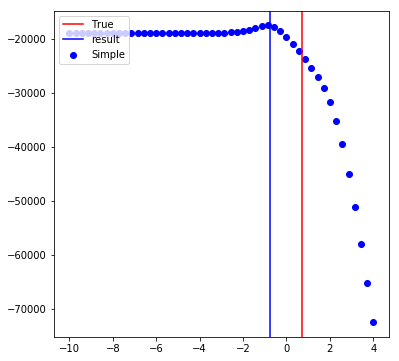

In [63]:
sigmabeta = np.logspace(-10, 4, 50)
true_alpha = np.log10(true_sigmabeta)
#print(true_sigmabeta)

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

ax1.scatter(np.log10(sigmabeta), ysimp,    color = 'blue', label = 'Simple')
#ax1.plot(np.log10(sigmabeta),    ycomp,    color = 'green', label = 'Complex')
#ax1.scatter(np.log10(sigmabeta), ycompsvd, color = 'salmon', label = 'Complex SVD')#'salmon'
print(true_alpha)
ax1.axvline(x = true_alpha, color = 'red', label = 'True')
ax1.axvline(x = np.log10(np.e ** -1.711663), color = 'blue', label = 'result')

plt.legend(loc = 'upper left')
plt.show()

In [56]:
-np.array(ysimp)

array([18768.87061849, 18768.87061819, 18768.87061757, 18768.87061624,
       18768.87061343, 18768.87060747, 18768.87059483, 18768.87056802,
       18768.87051116, 18768.87039055, 18768.87013475, 18768.86959222,
       18768.86844153, 18768.86600097, 18768.86082469, 18768.84984615,
       18768.82656158, 18768.77717787, 18768.67244523, 18768.45034742,
       18767.97944612, 18766.98139433, 18764.86774911, 18760.39903332,
       18750.98457035, 18731.29765441, 18690.76161754, 18609.88796998,
       18458.2451548 , 18204.95036407, 17859.63801545, 17531.94621344,
       17425.04283593, 17713.89426311, 18432.26775849, 19491.17830925,
       20771.05994218, 22183.8832598 , 23688.08766988, 25288.16926849,
       27043.78660185, 29094.56378397, 31676.77300228, 35073.60685061,
       39482.47100406, 44901.71615087, 51143.2897444 , 57944.77240438,
       65076.98132394, 72386.08293376])

In [ ]:
def numerical_gradient(X, Y, sbeta, sigmax, method='logml'):
    logsbeta = np.log(sbeta)
    delta = 0.001 * logsbeta
    sbeta_shifted = np.exp(logsbeta + delta)
    if method == 'logml':
        y    = logml(X, Y, sbeta, sigmax)
        ynew = logml(X, Y, sbeta_shifted, sigmax)
    elif method == 'logml_alt':
        y    = logml_alt(X, Y, sbeta, sigmax)
        ynew = logml_alt(X, Y, sbeta_shifted, sigmax)
    elif method == 'logml_alt_svd':
        y    = logml_alt_svd(X, Y, sbeta, sigmax)
        ynew = logml_alt_svd(X, Y, sbeta_shifted, sigmax)
    grad = (ynew - y) / delta
    return grad

#grad         = [numerical_gradient(X, Y, sbeta, sigmax, 'logml')         for sbeta in sigmabeta]
#grad_alt     = [numerical_gradient(X, Y, sbeta, sigmax, 'logml_alt')     for sbeta in sigmabeta]
grad_alt_svd = [numerical_gradient(gtcent, Y, sbeta, sigmax, 'logml_alt_svd') for sbeta in sigmabeta]

In [ ]:
grad_theory  = [grad_logml(gtcent, Y, sbeta, sigmax) for sbeta in sigmabeta]

In [ ]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

#ax1.scatter(np.log(sigmabeta), grad,         color = 'blue', label = 'Simple')
#ax1.plot   (np.log(sigmabeta), grad_alt,     color = 'green', label = 'Complex')
ax1.scatter(np.log(sigmabeta), grad_alt_svd, color = 'salmon', label = 'Numerical')
ax1.plot   (np.log(sigmabeta), grad_theory,  color = 'blue', label = 'Analytical')

ax1.axvline(x = true_alpha, color = 'red', label = 'True')

plt.legend(loc = 'upper left')
#ax1.set_ylim(-100000, 100000)
plt.show()

In [ ]:
# First term

def term1(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    return -0.5 * ngenes * np.log(2 * np.pi * sigmabeta2)

def term2(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax    
    Yt = Y.T # shape N x G
    A = np.dot(Yt.T, Yt)
    A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    logdetA = np.linalg.slogdet(A)
    return -0.5 * logdetA[1]

def term3(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax    
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    Smod = np.diag(np.square(S) / (np.square(S) + sigmax2 / sigmabeta2))
    W = np.dot(U, np.dot(Smod, U.T))
    i = 0
    res = 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2
    return res

def grad_term1(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    return -ngenes

def grad_term2(X, Y, sigmabeta, sigmax):
    nsamples = Y.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    Yt = Y.T
    #A = np.dot(Yt.T, Yt)
    #A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    #invA = np.linalg.inv(A)
    #der = sigmabeta2 * np.trace(invA * sigmax2 / sigmabeta2 / sigmabeta2)
    U, S, Vt = np.linalg.svd(Yt)
    Smod = np.zeros((ngenes, ngenes))
    Smod[np.arange(nsamples), np.arange(nsamples)] = np.square(S)
    Smod[np.diag_indices_from(Smod)] += sigmax2 / sigmabeta2
    B = np.linalg.multi_dot([Vt.T, Smod, Vt])
    invB = np.linalg.inv(B)
    der = sigmabeta2 * np.trace(invB * sigmax2 / sigmabeta2 / sigmabeta2) 
    #nsamples = X.shape[1]
    #sigmabeta2 = sigmabeta * sigmabeta
    #sigmax2    = sigmax    * sigmax
    #Yt = Y.T # shape N x G
    #U, S, Vt = np.linalg.svd(Yt)
    #der = 0
    #for k in range(U.shape[0]):
    #    sk = S[k]
    #    smod = sk * sk * sigmabeta2 / sigmax2
    #    der += 1 / (smod + 1)
    return der

def grad_term3(X, Y, sigmabeta, sigmax):
    nsamples = X.shape[1]
    nsnps = X.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    der = 0
    for k in range(nsamples):
        sk = S[k]
        uk = U[:, k]
        snppart = np.square(np.dot(uk, X[0,:]))
        smod = sk * sk * sigmabeta2 / sigmax2
        der += smod * snppart / sigmax2 / np.square(smod + 1)
    return der

def grad_numeric(X, Y, sigmabeta, sigmax, method = 'term1'):
    logsbeta = np.log(sigmabeta)
    delta = 0.00001 * logsbeta
    sigmabeta_shifted = np.exp(logsbeta + delta)
    if method == 'term1':
        y    = term1(X, Y, sigmabeta, sigmax)
        ynew = term1(X, Y, sigmabeta_shifted, sigmax)
    elif method == 'term2':
        y    = term2(X, Y, sigmabeta, sigmax)
        ynew = term2(X, Y, sigmabeta_shifted, sigmax)
    elif method == 'term3':
        y    = term3(X, Y, sigmabeta, sigmax)
        ynew = term3(X, Y, sigmabeta_shifted, sigmax)
    grad = (ynew - y) / delta
    return grad

In [ ]:
y1 = [term1(X, Y, sbeta, 1) for sbeta in sigmabeta]
y1_gradnumeric = [grad_numeric(X, Y, sbeta, 1, 'term1') for sbeta in sigmabeta]
y1_gradtheory  = [grad_term1(X, Y, sbeta, 1) for sbeta in sigmabeta]

In [ ]:
y2 = [term2(X, Y, sbeta, 1) for sbeta in sigmabeta]
y2_gradnumeric = [grad_numeric(X, Y, sbeta, 1, 'term2') for sbeta in sigmabeta]
y2_gradtheory  = [grad_term2(X, Y, sbeta, 1) for sbeta in sigmabeta]

In [ ]:
y3 = [term3(X, Y, sbeta, 1) for sbeta in sigmabeta]
y3_gradnumeric = [grad_numeric(X, Y, sbeta, 1, 'term3') for sbeta in sigmabeta]
y3_gradtheory  = [grad_term3(X, Y, sbeta, 1) for sbeta in sigmabeta]

In [ ]:
fig = plt.figure(figsize = (12, 24))
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)


ax1.scatter(np.log(sigmabeta), y1, color = 'blue')
ax2.scatter(np.log(sigmabeta), y1_gradnumeric, color = 'blue', label = 'Numeric')
ax2.plot(np.log(sigmabeta), y1_gradtheory,  color = 'salmon', label = 'Theory')

ax3.scatter(np.log(sigmabeta), y2, color = 'blue')
ax4.scatter(np.log(sigmabeta), y2_gradnumeric, color = 'blue', label = 'Numeric')
ax4.plot(np.log(sigmabeta), y2_gradtheory,  color = 'salmon', label = 'Theory')

ax5.scatter(np.log(sigmabeta), y3, color = 'blue')
ax6.scatter(np.log(sigmabeta), y3_gradnumeric, color = 'blue', label = 'Numeric')
ax6.plot(np.log(sigmabeta), y3_gradtheory,  color = 'salmon', label = 'Theory')

y = [sum(x) for x in zip(y1, y2, y3)]
y_gradnumeric = [sum(x) for x in zip(y1_gradnumeric, y2_gradnumeric, y3_gradnumeric)]
y_gradtheory = [sum(x) for x in zip(y1_gradtheory, y2_gradtheory, y3_gradtheory)]
ax7.scatter(np.log(sigmabeta), y, color = 'blue')
ax8.scatter(np.log(sigmabeta), y_gradnumeric, color = 'blue', label = 'Numeric')
ax8.plot(np.log(sigmabeta), y_gradtheory,  color = 'salmon', label = 'Theory')

ax2.legend(loc = 'lower right')
ax4.legend(loc = 'upper right')
#ax1.set_ylim(-100000, 100000)
plt.show()

In [ ]:
np.std(X,axis = 1).shape

In [ ]:
1/2 * np.identity(3) + [[1,2,3],[2,3,4],[4,5,6]]

In [ ]:
np.log(0.008)

In [ ]:
np.e ** 0.3

In [61]:
np.log(5)

1.6094379124341003

In [3]:
gtcent = np.array([[1,2],[3,4],[5,7]])

In [8]:
np.std(gtcent,axis = 1)

array([0.5, 0.5, 1. ])